In [2]:
# Imports
from prelim_calculations import Calculate
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import csv
from demand_calculation import *
import os
import time

In [3]:
class Request:

    def __init__(self):
        self.API_URL = "https://phonebox.tegola.org.uk/api_jsonrpc.php"
        self.NUM_VALUES = 1        # Data is collected every 3 minutes
        self.username = "yeyao"
        self.password = "ci5WeJoh"

        # Router -> Internet IDs
        # order: mhi,blo,cor,pho,bco,smo,cam,usgr,ssh,lsgr
        self.rti_ids = [["47072", "47073", "47068", "47061"], ["46494"], ["46640", "46641"], ["52250", "44809", "44811", "48758", "48759", "48760", "48761"], ["46367", "46359", "46362", "46365", "46366"], ["47707", "47722", "47711"], ["46131"], ["45626", "45625", "45639"], ["45623"]]

        # Internet -> Router IDs
        self.itr_ids = [["47123", "47124", "47119", "47112"], ["46539"], ["46682", "46683"], ["44896", "44898", "48803", "48804", "48805", "48806", "52256"], ["46404", "46407", "46410", "46411", "46412"], ["47851", "47866", "47855"], ["46074"], ["45794", "45793", "45807"], ["45791"]]
        
        self.mhi_gateway_upstream_id = "47118"
        self.mhi_gateway_downstream_id = "47067"
        self.smo_gateway_upstream_id = "47852"
        self.smo_gateway_downstream_id = "47708"
        self.gateway_id_list = [self.mhi_gateway_upstream_id, self.mhi_gateway_downstream_id, self.smo_gateway_upstream_id, self.smo_gateway_downstream_id]
        self.token = self.get_auth_token()

    # Generate the authentication token for login
    def get_auth_token(self):
        result = ""

        # JSON login request
        try:
            data = {
            "jsonrpc": "2.0",
            "method": "user.login",
            "params": {
                "user": self.username,
                "password": self.password
            },
            "id": 1,
            "auth": None
            }
            req = requests.post(self.API_URL, json=data)
            result = req.json()["result"]
        except:
            exit()
        return result

    # Build a trend request
    def build(self, start, end, ids):
        data = {
            "jsonrpc": "2.0",
            "method": "trend.get",
            "params": {
                "time_from": int(time.mktime(start)),
                "time_till": int(time.mktime(end)),
                "itemids": ids,
                "sortfield": "clock",
                "sortorder": "DESC",
                "output": [
                    "itemid",
                    "clock",
                    "value_avg" # should be able to change this to max/min if necessary
                ]
            },
            "auth": self.token,
            "id": 1
        }

        req = requests.post(API_URL, json=data)
        return ast.literal_eval(req.text)["result"]

In [4]:
# Gather the traffic for a 5-day period to show the cyclic nature of the traffic and peak times

start_date = datetime.datetime(2023, 2, 1, 0, 0).timetuple()
end_date = datetime.datetime(2023, 2, 6, 0, 0).timetuple()
req = Request()

gateway_dataset = [req.build(start_date, end_date, id) for id in req.gateway_id_list]

(array([19389.25, 19389.75, 19390.25, 19390.75, 19391.25, 19391.75,
        19392.25, 19392.75, 19393.25, 19393.75]),
 [Text(19389.25, 0, 'Wed - 06:00'),
  Text(19389.75, 0, 'Wed - 18:00'),
  Text(19390.25, 0, 'Thu - 06:00'),
  Text(19390.75, 0, 'Thu - 18:00'),
  Text(19391.25, 0, 'Fri - 06:00'),
  Text(19391.75, 0, 'Fri - 18:00'),
  Text(19392.25, 0, 'Sat - 06:00'),
  Text(19392.75, 0, 'Sat - 18:00'),
  Text(19393.25, 0, 'Sun - 06:00'),
  Text(19393.75, 0, 'Sun - 18:00')])

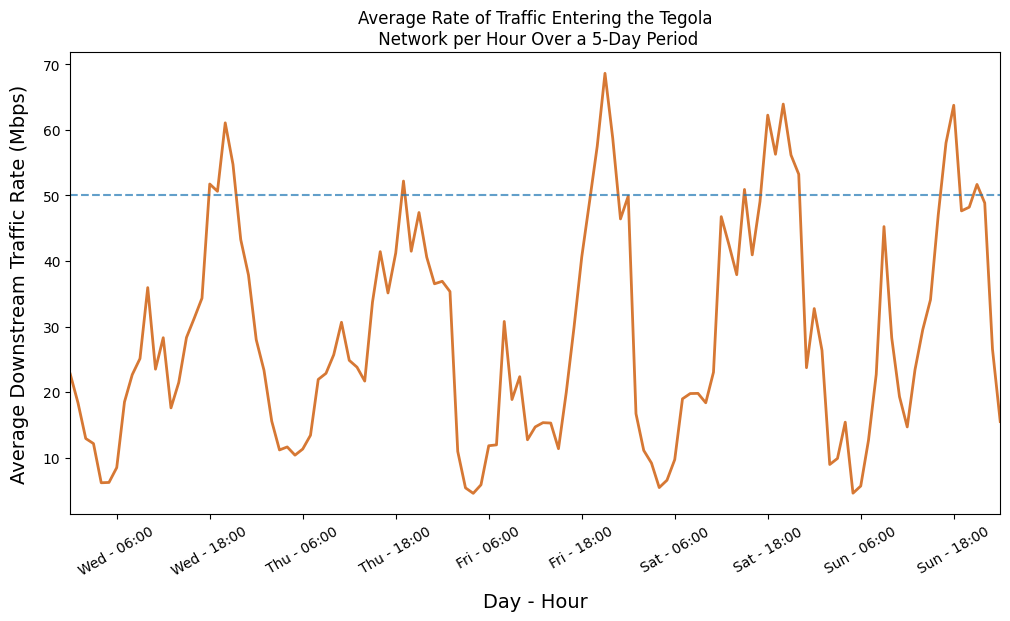

In [5]:
# Clean and plot the data for 5-day period
import matplotlib.dates as mdates
times = np.arange(1675231200, 1675641600, 43200)
gateway_df = pd.DataFrame()
gateway_df["time"] = pd.DataFrame.from_records(gateway_dataset[0])["clock"]
i = 0
for item in gateway_dataset:
    df_temp = pd.DataFrame.from_records(item)
    gateway_df[str(i)] = df_temp["value_avg"].astype(int) * 0.000001
    i += 1
gateway_df["4"] = gateway_df.loc[:,['2','3']].sum(axis=1)
gateway_df["5"] = gateway_df["time"].apply(lambda x: datetime.datetime.fromtimestamp(int(x)))
xmin = datetime.datetime.fromtimestamp(1675209600)
xmax = datetime.datetime.fromtimestamp(1675641600)
fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax.plot(gateway_df["5"], gateway_df["4"], color="chocolate", alpha = 0.9, linewidth = 2)
ax.hlines(50, xmin, xmax, linestyle = 'dashed', alpha = 0.7)
ax.set_ylabel("Average Downstream Traffic Rate (Mbps)", fontsize=14, labelpad=10)
ax.set_xlabel("Day - Hour", fontsize=14, labelpad=10)
ax.set_title("Average Rate of Traffic Entering the Tegola\n Network per Hour Over a 5-Day Period")
ax.set_xlim(xmin, xmax)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a - %H:%M'))
ax.set_xticks([datetime.datetime.fromtimestamp(x) for x in times])
plt.xticks(rotation=30)

In [6]:
# Retrieve all the data for the last month of gateway traffic
start_date = datetime.datetime(2023, 1, 1, 0, 0).timetuple()
end_date = datetime.datetime(2023, 1, 31, 23, 59).timetuple()
req = Request()
# item 1: upstream mhi, item 2: downstream mhi, item 3: upstream smo, item 4: downstream smo
gateway_dataset = [req.build(start_date, end_date, id) for id in req.gateway_id_list]

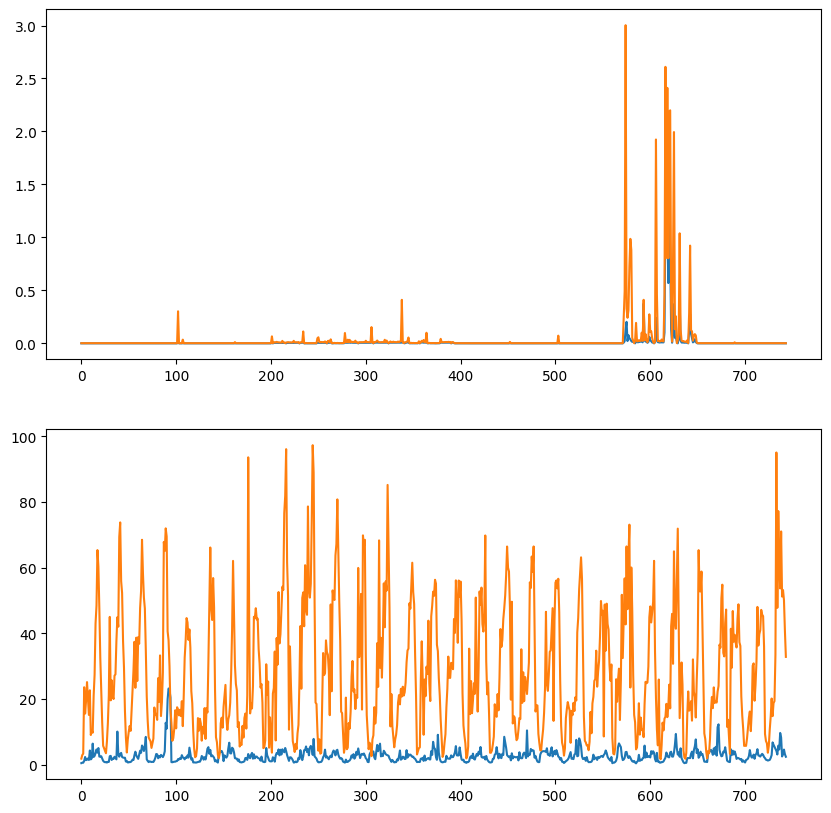

In [7]:
# Build and plot graphs for the average network traffic every hour over a monthlong period
gateway_df = pd.DataFrame()
gateway_df["time"] = pd.DataFrame.from_records(gateway_dataset[0])["clock"]
i = 0
for item in gateway_dataset:
    df_temp = pd.DataFrame.from_records(item)
    gateway_df[str(i)] = df_temp["value_avg"].astype(int) * 0.000001
    i += 1
fig, ax = plt.subplots(2,1, figsize=(10,10))
ax[0].plot(gateway_df["0"])
ax[0].plot(gateway_df["1"])
ax[1].plot(gateway_df["2"])
ax[1].plot(gateway_df["3"])

(0.0, 30.0)

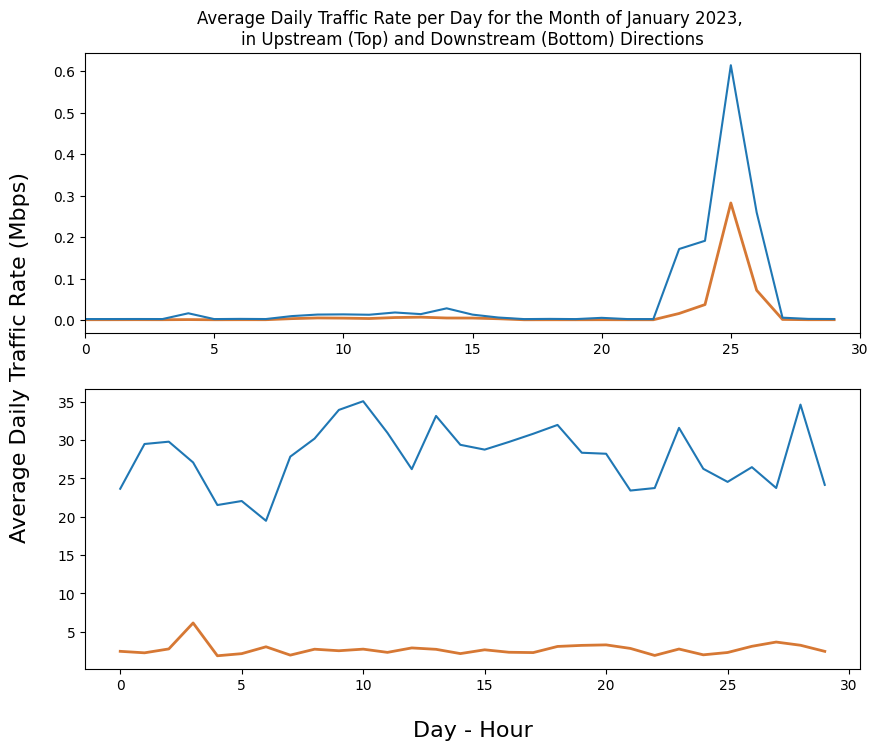

In [8]:
# Adjust timescale to per-day traffic and plot for a less noisy graph
new_df = pd.DataFrame()
for j in range(4):
    new = np.zeros(30)
    for i in range(30):
        x = gateway_df[str(j)][24 * i:24 * (i + 1)]
        new[i] = sum(x) / 24
    new_df[str(j)] = new

fig, ax = plt.subplots(2,1, figsize=(10,8))
ax[0].plot(new_df["0"], color="chocolate", alpha = 0.9, linewidth = 2)
ax[0].plot(new_df["1"])
ax[1].plot(new_df["2"], color="chocolate", alpha = 0.9, linewidth = 2)
ax[1].plot(new_df["3"])
#ax[0].set_ylabel("Average Downstream Traffic Rate (Mbps)", fontsize=14, labelpad=10)
fig.text(0.06, 0.5, 'Average Daily Traffic Rate (Mbps)', ha='center', va='center', rotation='vertical', fontsize=16)
ax[1].set_xlabel("Day - Hour", fontsize=16, labelpad=20)
ax[0].set_title("Average Daily Traffic Rate per Day for the Month of January 2023, \nin Upstream (Top) and Downstream (Bottom) Directions")
ax[0].set_xlim(0, 30)
ax[0].set_xlim(0, 30)

In [9]:
# Setup the requests for data from each switch
start_date = datetime.datetime(2023, 1, 1, 0, 0).timetuple()
end_date = datetime.datetime(2023, 2, 1, 0, 0).timetuple()
req = Request()

rti_dataset = [req.build(start_date, end_date, id) for id in req.rti_ids]
itr_dataset = [req.build(start_date, end_date, id) for id in req.itr_ids]

34.46797576375839


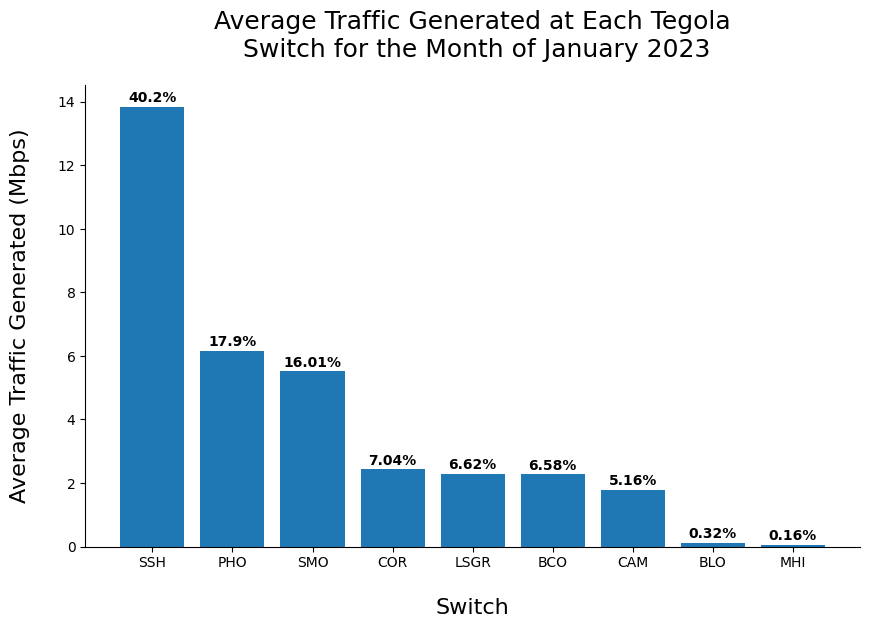

In [39]:
keys = ["MHI", "BLO", "COR", "PHO", "BCO", "SMO", "CAM", "SSH", "LSGR"]
dict = {}

for i in range(len(rti_dataset)):
    df_temp = pd.DataFrame.from_records(rti_dataset[i])
    df_temp["value_avg"] = pd.to_numeric(df_temp["value_avg"])
    df_temp = df_temp.groupby(df_temp['clock']).aggregate({'clock': 'first', 'value_avg': 'sum'})
    interface_sum = sum(df_temp["value_avg"]) / 745
    dict[keys[i]] = interface_sum

for i in range(len(itr_dataset)):
    df_temp = pd.DataFrame.from_records(itr_dataset[i])
    df_temp["value_avg"] = pd.to_numeric(df_temp["value_avg"])
    df_temp = df_temp.groupby(df_temp['clock']).aggregate({'clock': 'first', 'value_avg': 'sum'})
    interface_sum = sum(df_temp["value_avg"]) / 745
    dict[keys[i]] = (dict[keys[i]] + interface_sum) * 0.000001

df = pd.DataFrame.from_dict(dict, orient="index", columns=["value_avg"])
df = df.sort_values(["value_avg"], ascending=False)
total = sum(df["value_avg"])
df["percentage"] = (df["value_avg"] / total) * 100
df["percentage"] = df["percentage"].round(2)
fig, ax = plt.subplots(1,1, figsize=(10,6))
graph = ax.bar(df.index, df["value_avg"])
ax.set_xlabel("Switch", fontsize=16, labelpad=20)
ax.set_ylabel("Average Traffic Generated (Mbps)", fontsize=16, labelpad=20)
ax.set_title("Average Traffic Generated at Each Tegola\n Switch for the Month of January 2023", fontsize=18, pad=20)
ax.spines[['right', 'top']].set_visible(False)

# Print the percentage of total traffic above the bar
i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
     
    plt.text(x+width/2,
             y+height+0.15,
             str(df.percentage[i])+'%',
             ha='center',
             weight='bold')
    i += 1
print(total)